# Import

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, butter, sosfilt, sosfreqz, freqz, resample
import soundfile as sf

# Paramètres globaux

In [34]:
fs = 24000 # fréquence d'échantillonnage
bands = np.arange(22, 40)   # bande 22 → 39
Nbands = len(bands) # nombre de bandes

# Calcul des fréquences ANSI 1/3 octave

In [35]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

# stockage des filtres
filters_FIR = []
filters_IIR = []

# Design des filtres FIR et IIR

In [36]:
for n in bands:
    # Pour chaque bande ANSI, on calcule les fréquences de coupure et on normalise (scipy)
    fl, f0, fu = ansi_band(n)
    
    fl /= fs/2
    fu /= fs/2

    # FIR 1/3 octave (bandpass)
    taps = firwin(                 # design FIR windowed (méthode de Hamming)
        numtaps=129,               # (ordre 128)
        cutoff=[fl, fu],           # bande passante
        pass_zero=False
    )
    filters_FIR.append(taps)

    # IIR Butterworth
    sos = butter(                  # filtre IIR Butterworth d’ordre 4
        N=4,
        Wn=[fl, fu],
        btype='bandpass',
        output='sos'               # second-order sections
    )
    filters_IIR.append(sos)

print("Les 18 filtres 1/3-octave ont été générés avec succès !")

Les 18 filtres 1/3-octave ont été générés avec succès !


Juste pour rappelle :')
Un SOS d'ordre 2 (ce que l'on a) est de la forme :

$$H_i(z) = 
\frac{
b_{0,i} + b_{1,i} z^{-1} + b_{2,i} z^{-2}
}{
1 + a_{1,i} z^{-1} + a_{2,i} z^{-2}
}
$$

# Plot des réponses fréquentielles (FIR)

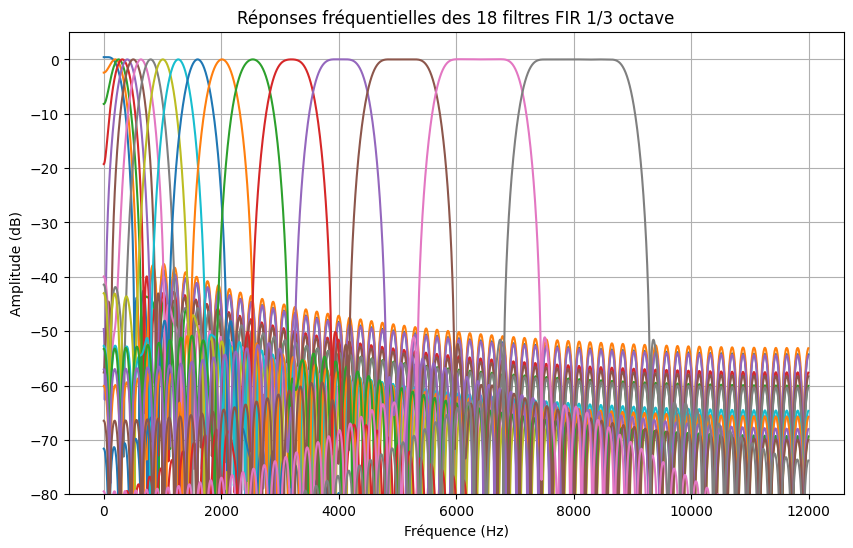

In [37]:
plt.figure(figsize=(10,6))
for taps in filters_FIR:
    w, h = freqz(taps, [1], worN=2048, fs=fs) # réponse en fréquence FIR
    plt.plot(w, 20*np.log10(np.abs(h)))

plt.title("Réponses fréquentielles des 18 filtres FIR 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

# Test sur audio

In [38]:
signal, fs_in = sf.read("test.wav")

# Convertir en mono si stéréo
if signal.ndim > 1:
    signal = np.mean(signal, axis=1)

# Resample si besoin
if fs_in != fs:
    signal = resample(signal, int(len(signal) * fs / fs_in))
    print(f"Audio resamplé de {fs_in} Hz à {fs} Hz")

filtered_bands = []

#for taps in filters_FIR:
#    filtered_sig = np.convolve(signal, taps, mode='same')

for sos in filters_IIR:
    filtered_sig = sosfilt(sos, signal)
    filtered_bands.append(filtered_sig)

filtered_bands = np.array(filtered_bands).T

print("Filtrage terminé !")

Audio resamplé de 44100 Hz à 24000 Hz
Filtrage terminé !
Filtrage terminé !


# Sauvegarde des bandes filtrées

In [39]:
# Sauvegarde des bandes filtrées
import os
if not os.path.exists('filtered_bands'):
    os.makedirs('filtered_bands')

for i, band in enumerate(bands):
    filename = f"filtered_bands/band_{band}.wav"
    sf.write(filename, filtered_bands[:, i], fs)
    print(f"Bande {band} sauvegardée dans {filename}")

print("Toutes les bandes filtrées ont été sauvegardées !")

Bande 22 sauvegardée dans filtered_bands/band_22.wav
Bande 23 sauvegardée dans filtered_bands/band_23.wav
Bande 24 sauvegardée dans filtered_bands/band_24.wav
Bande 25 sauvegardée dans filtered_bands/band_25.wav
Bande 26 sauvegardée dans filtered_bands/band_26.wav
Bande 27 sauvegardée dans filtered_bands/band_27.wav
Bande 28 sauvegardée dans filtered_bands/band_28.wav
Bande 29 sauvegardée dans filtered_bands/band_29.wav
Bande 30 sauvegardée dans filtered_bands/band_30.wav
Bande 31 sauvegardée dans filtered_bands/band_31.wav
Bande 32 sauvegardée dans filtered_bands/band_32.wav
Bande 33 sauvegardée dans filtered_bands/band_33.wav
Bande 34 sauvegardée dans filtered_bands/band_34.wav
Bande 35 sauvegardée dans filtered_bands/band_35.wav
Bande 36 sauvegardée dans filtered_bands/band_36.wav
Bande 37 sauvegardée dans filtered_bands/band_37.wav
Bande 38 sauvegardée dans filtered_bands/band_38.wav
Bande 39 sauvegardée dans filtered_bands/band_39.wav
Toutes les bandes filtrées ont été sauvegardée

# Plot de comparaison FIR vs IIR

/tmp/ipykernel_349609/3274457603.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")


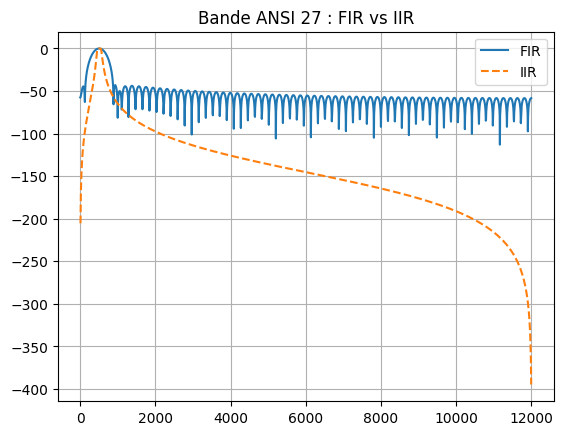

In [40]:
k = 5  # bande 27
taps = filters_FIR[k]
sos = filters_IIR[k]

# FIR
w, h = freqz(taps, [1], worN=2048, fs=fs)
plt.plot(w, 20*np.log10(np.abs(h)), label="FIR")

# IIR
w2, h2 = sosfreqz(sos, worN=2048, fs=fs)
plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")

plt.legend()
plt.grid(True)
plt.title(f"Bande ANSI {bands[k]} : FIR vs IIR")
plt.show()